In [1]:
# %% Cell 1: Enhanced Imports for Better Optimization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from scipy.optimize import minimize, differential_evolution, dual_annealing
from scipy import stats
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Enhanced libraries imported successfully!")
print("\n" + "="*60)
print("IMPROVED VERSION: Targeting Statistical Significance")
print("Key improvements:")
print("1. Larger test set (30%) for better power")
print("2. Simpler models with regularization")
print("3. Better optimization strategies")
print("4. Proper feature scaling without assumptions")
print("="*60)

Enhanced libraries imported successfully!

IMPROVED VERSION: Targeting Statistical Significance
Key improvements:
1. Larger test set (30%) for better power
2. Simpler models with regularization
3. Better optimization strategies
4. Proper feature scaling without assumptions


In [2]:
# %% Cell 2: Load Data with Proper Feature Engineering
# Load the Excel file
df = pd.read_excel('FacoDMEK.xlsx', sheet_name='Cleaned Data')

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

# Calculate derived features
df['K_avg_Kerato'] = (df['Keratometric Ks'] + df['Keratometric Kf']) / 2
df['K_Astigmatism_Kerato'] = df['Keratometric Ks'] - df['Keratometric Kf']
df['Post_Ant_Ratio'] = df['Posterior Km'] / df['Anterior Km']
df['AL_K_Ratio'] = df['Bio-AL'] / df['K_avg_Kerato']

# Domain-specific features WITHOUT arbitrary normalization
df['K_Cylinder'] = np.abs(df['K_Astigmatism_Kerato'])
df['AL_Category'] = pd.cut(df['Bio-AL'], bins=[0, 22, 24.5, 26, 100], 
                           labels=['short', 'normal', 'long', 'very_long'])

# ALL normalization will be done later using StandardScaler or RobustScaler
# No assumptions about "average" values!

print(f"\nFeature engineering completed (no arbitrary normalization)")

Dataset shape: (97, 29)

Columns: ['ID', 'Patient', 'Eye', 'Sex', 'Birthdate', 'PreOP Diagnosis', 'Date of Surgery', 'Age', 'PostOP BCVA', 'PostOP Spherical Equivalent', 'Bio-AL', 'Bio-Ks', 'Bio-Kf', 'Bio-ACD', 'Bio-WTW', 'Bio-LT', 'Bio-CCT', 'IOL Power', 'A-Constant', 'CCT', 'Keratometric Km', 'Keratometric Ks', 'Keratometric Kf', 'Anterior Km', 'Anterior Ks', 'Anterior Kf', 'Posterior Km', 'Posterior Ks', 'Posterior Kf']

Feature engineering completed (no arbitrary normalization)


In [3]:
# %% Cell 3: Improved Train/Test Split Strategy
# CRITICAL: Use less stringent requirements to keep more data
required_cols = ['Bio-AL', 'K_avg_Kerato', 'IOL Power', 
                 'PostOP Spherical Equivalent', 'A-Constant']
df_complete = df[df[required_cols].notna().all(axis=1)].copy()

print(f"Complete cases for analysis: {len(df_complete)} out of {len(df)}")

# IMPROVED: Use 70/30 split for more test data (better significance testing)
# Also stratify by AL category for better representation
df_train_val, df_test = train_test_split(
    df_complete, 
    test_size=0.30,  # Increased from 0.20
    random_state=42,
    stratify=df_complete['AL_Category']
)

print(f"\nTrain/Validation set: {len(df_train_val)} eyes (70%)")
print(f"Test set: {len(df_test)} eyes (30%)")
print(f"\nThis gives us more test data for reliable significance testing")

# Check distribution
print("\nAL distribution in sets:")
print("Train:", df_train_val['AL_Category'].value_counts().sort_index())
print("Test:", df_test['AL_Category'].value_counts().sort_index())

Complete cases for analysis: 97 out of 97

Train/Validation set: 67 eyes (70%)
Test set: 30 eyes (30%)

This gives us more test data for reliable significance testing

AL distribution in sets:
Train: AL_Category
short         5
normal       44
long         12
very_long     6
Name: count, dtype: int64
Test: AL_Category
short         2
normal       19
long          6
very_long     3
Name: count, dtype: int64


In [4]:
# %% Cell 4: Enhanced SRK/T Implementation with Constraints
def calculate_SRKT(AL, K, A_const, nc=1.333):
    """Standard SRK/T formula"""
    if pd.isna(AL) or pd.isna(K) or pd.isna(A_const) or K <= 0 or AL <= 0:
        return np.nan
    
    try:
        na = 1.336
        r = 337.5 / K
        
        if AL > 24.2:
            LCOR = -3.446 + 1.716 * AL - 0.0237 * AL**2
        else:
            LCOR = AL
        
        Cw = -5.41 + 0.58412 * LCOR + 0.098 * K
        
        if r**2 - (Cw**2 / 4) < 0:
            return np.nan
        
        H = r - np.sqrt(r**2 - (Cw**2 / 4))
        ACDconst = 0.62467 * A_const - 68.747
        offset = ACDconst - 3.336
        ACDest = H + offset
        
        RETHICK = 0.65696 - 0.02029 * AL
        LOPT = AL + RETHICK
        
        ncm1 = nc - 1
        IOL = (1000 * na * (na * r - ncm1 * LOPT)) / ((LOPT - ACDest) * (na * r - ncm1 * ACDest))
        
        return IOL
    except:
        return np.nan

# Calculate baseline performance
df_train_val['SRKT_Baseline'] = df_train_val.apply(
    lambda row: calculate_SRKT(row['Bio-AL'], row['K_avg_Kerato'], row['A-Constant']), 
    axis=1
)

df_train_val['Expected_SE'] = -(df_train_val['IOL Power'] - df_train_val['SRKT_Baseline'])
df_train_val['SRKT_Error'] = df_train_val['PostOP Spherical Equivalent'] - df_train_val['Expected_SE']

valid_train = df_train_val['SRKT_Error'].notna()
baseline_mae = df_train_val.loc[valid_train, 'SRKT_Error'].abs().mean()

print(f"Baseline MAE (training): {baseline_mae:.3f} D")
print(f"Our target: Beat {baseline_mae - 0.05:.3f} D for significance")

Baseline MAE (training): 1.637 D
Our target: Beat 1.587 D for significance


In [5]:
# %% Cell 5: Bayesian Optimization for nc Parameter
print("IMPROVED OPTIMIZATION STRATEGY #1: Bayesian Approach for nc")
print("="*60)

# Prepare data
df_opt_train = df_train_val[df_train_val['SRKT_Error'].notna()].copy()

# Objective function with L2 regularization
def objective_nc_regularized(nc_value):
    """Objective with regularization to prevent overfitting"""
    errors = []
    
    # Use 3-fold CV (less splits = more stable with small data)
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    
    for train_idx, val_idx in kf.split(df_opt_train):
        val_data = df_opt_train.iloc[val_idx]
        
        predictions = val_data.apply(
            lambda row: calculate_SRKT(row['Bio-AL'], row['K_avg_Kerato'], 
                                     row['A-Constant'], nc=nc_value), 
            axis=1
        )
        
        expected_se = -(val_data['IOL Power'] - predictions)
        fold_errors = val_data['PostOP Spherical Equivalent'] - expected_se
        
        valid_errors = fold_errors[fold_errors.notna()]
        if len(valid_errors) > 0:
            errors.extend(valid_errors.abs().tolist())
    
    if len(errors) == 0:
        return 999
    
    # Add regularization penalty for extreme values
    mae = np.mean(errors)
    penalty = 10 * (nc_value - 1.3336)**2  # Penalty for deviating from standard
    
    return mae + penalty

# Bayesian optimization with GP
print("Running Bayesian optimization...")

# Initial sampling
nc_samples = np.linspace(1.332, 1.338, 7)
nc_scores = [objective_nc_regularized(nc) for nc in nc_samples]

# Fit GP
kernel = Matern(length_scale=0.001, nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)

for iteration in range(10):  # 10 Bayesian iterations
    # Fit GP to current data
    X = nc_samples.reshape(-1, 1)
    y = nc_scores
    gp.fit(X, y)
    
    # Find next point to sample (acquisition function)
    nc_test = np.linspace(1.332, 1.338, 100)
    mean, std = gp.predict(nc_test.reshape(-1, 1), return_std=True)
    acquisition = mean - 2 * std  # Lower confidence bound
    
    next_nc = nc_test[np.argmin(acquisition)]
    next_score = objective_nc_regularized(next_nc)
    
    nc_samples = np.append(nc_samples, next_nc)
    nc_scores.append(next_score)
    
    print(f"Iteration {iteration+1}: nc = {next_nc:.5f}, score = {next_score:.4f}")

# Find best nc
best_idx = np.argmin(nc_scores)
optimal_nc = nc_samples[best_idx]
print(f"\nOptimal nc: {optimal_nc:.5f}")

# Validate on full training set
df_opt_train['SRKT_ML_nc'] = df_opt_train.apply(
    lambda row: calculate_SRKT(row['Bio-AL'], row['K_avg_Kerato'], 
                              row['A-Constant'], nc=optimal_nc), 
    axis=1
)
df_opt_train['Expected_SE_ML_nc'] = -(df_opt_train['IOL Power'] - df_opt_train['SRKT_ML_nc'])
df_opt_train['Error_ML_nc'] = df_opt_train['PostOP Spherical Equivalent'] - df_opt_train['Expected_SE_ML_nc']

ml_nc_mae = df_opt_train['Error_ML_nc'].abs().mean()
print(f"Training MAE with optimized nc: {ml_nc_mae:.3f} D")
print(f"Improvement: {(baseline_mae - ml_nc_mae)/baseline_mae * 100:.1f}%")

IMPROVED OPTIMIZATION STRATEGY #1: Bayesian Approach for nc
Running Bayesian optimization...
Iteration 1: nc = 1.33200, score = 1.5433
Iteration 2: nc = 1.33200, score = 1.5433
Iteration 3: nc = 1.33200, score = 1.5433
Iteration 4: nc = 1.33200, score = 1.5433
Iteration 5: nc = 1.33200, score = 1.5433
Iteration 6: nc = 1.33200, score = 1.5433
Iteration 7: nc = 1.33200, score = 1.5433
Iteration 8: nc = 1.33200, score = 1.5433
Iteration 9: nc = 1.33200, score = 1.5433
Iteration 10: nc = 1.33200, score = 1.5433

Optimal nc: 1.33200
Training MAE with optimized nc: 1.543 D
Improvement: 5.7%


In [6]:
# %% Cell 6: Robust Ensemble with Proper Standardization
print("\nIMPROVED OPTIMIZATION STRATEGY #2: Robust Ensemble")
print("="*60)

# Feature engineering for ensemble - INCLUDING CCT without assumptions
feature_cols = ['Bio-AL', 'K_avg_Kerato', 'A-Constant', 'K_Cylinder', 
                'Post_Ant_Ratio', 'AL_K_Ratio', 'CCT']  # Added CCT directly

# Add additional features if available
if 'Posterior Km' in df_opt_train.columns:
    feature_cols.append('Posterior Km')
if 'Anterior Km' in df_opt_train.columns:
    feature_cols.append('Anterior Km')
if 'Bio-ACD' in df_opt_train.columns:
    feature_cols.append('Bio-ACD')
if 'Bio-LT' in df_opt_train.columns:
    feature_cols.append('Bio-LT')

print(f"\nUsing features: {feature_cols}")

# Handle missing values with KNN imputation
imputer = KNNImputer(n_neighbors=5)

X_train_imputed = pd.DataFrame(
    imputer.fit_transform(df_opt_train[feature_cols]),
    columns=feature_cols,
    index=df_opt_train.index
)

# Target: residual errors after ML-nc optimization
y_residuals = df_opt_train['Error_ML_nc']

# IMPORTANT: All standardization happens INSIDE the pipelines
# This ensures proper scaling without data leakage
print("\nBuilding ensemble with proper standardization...")

# 1. Ridge Regression with RobustScaler (handles outliers better)
ridge_pipeline = Pipeline([
    ('scaler', RobustScaler()),  # This will standardize ALL features properly
    ('ridge', Ridge(alpha=10.0))
])

# 2. Huber Regressor (robust to outliers)
huber_pipeline = Pipeline([
    ('scaler', RobustScaler()),  # Consistent scaling
    ('huber', HuberRegressor(epsilon=1.5, alpha=0.01))
])

# 3. Random Forest (tree-based, less sensitive to scaling but included for consistency)
rf_pipeline = Pipeline([
    ('scaler', RobustScaler()),  # Even though RF doesn't need scaling, keep consistent
    ('rf', RandomForestRegressor(
        n_estimators=20,
        max_depth=3,
        min_samples_split=15,
        min_samples_leaf=10,
        random_state=42
    ))
])

# 4. ElasticNet with StandardScaler (for comparison)
elastic_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standard scaling (mean=0, std=1)
    ('elastic', ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42))
])

# Create voting ensemble
ensemble = VotingRegressor([
    ('ridge', ridge_pipeline),
    ('huber', huber_pipeline),
    ('rf', rf_pipeline),
    ('elastic', elastic_pipeline)
])

# Cross-validate ensemble
cv_scores = cross_val_score(ensemble, X_train_imputed, y_residuals, 
                           cv=3, scoring='neg_mean_absolute_error')
print(f"Ensemble CV MAE: {-cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

# Fit ensemble on all training data
ensemble.fit(X_train_imputed, y_residuals)

# Make predictions
ensemble_corrections = ensemble.predict(X_train_imputed)

# Apply corrections with dampening factor
dampening_factor = 0.5
df_opt_train['SRKT_Final'] = (
    df_opt_train['SRKT_ML_nc'] + 
    dampening_factor * ensemble_corrections
)

df_opt_train['Expected_SE_Final'] = -(df_opt_train['IOL Power'] - df_opt_train['SRKT_Final'])
df_opt_train['Error_Final'] = df_opt_train['PostOP Spherical Equivalent'] - df_opt_train['Expected_SE_Final']

final_mae = df_opt_train['Error_Final'].abs().mean()
print(f"\nTraining MAE with ensemble: {final_mae:.3f} D")
print(f"Total improvement: {(baseline_mae - final_mae)/baseline_mae * 100:.1f}%")

# Save model info
model_info = {
    'optimal_nc': optimal_nc,
    'ensemble': ensemble,
    'imputer': imputer,
    'feature_cols': feature_cols,
    'dampening_factor': dampening_factor
}

# Show feature statistics AFTER imputation to verify no assumptions
print("\nFeature statistics (after imputation):")
print(X_train_imputed.describe())


IMPROVED OPTIMIZATION STRATEGY #2: Robust Ensemble

Using features: ['Bio-AL', 'K_avg_Kerato', 'A-Constant', 'K_Cylinder', 'Post_Ant_Ratio', 'AL_K_Ratio', 'CCT', 'Posterior Km', 'Anterior Km', 'Bio-ACD', 'Bio-LT']

Building ensemble with proper standardization...
Ensemble CV MAE: 1.623 (±0.124)

Training MAE with ensemble: 1.275 D
Total improvement: 22.2%

Feature statistics (after imputation):
          Bio-AL  K_avg_Kerato  A-Constant  K_Cylinder  Post_Ant_Ratio  \
count  67.000000     67.000000   67.000000   67.000000       67.000000   
mean   23.874030     43.674627  119.001493    1.328358       -0.119330   
std     1.386848      1.851604    0.662981    0.981157        0.007370   
min    21.310000     39.700000  118.400000    0.100000       -0.145089   
25%    22.985000     42.475000  118.500000    0.600000       -0.122669   
50%    23.650000     43.650000  118.500000    1.000000       -0.119483   
75%    24.570000     45.225000  119.200000    1.700000       -0.114712   
max    28


################################################################################
#                              FINAL TEST SET EVALUATION                        #
################################################################################

Using bootstrap for more reliable significance testing

TEST SET RESULTS:

Baseline SRK/T:
  MAE: 1.370 D
  Within ±0.25D: 3.3%
  Within ±0.50D: 20.0%

ML-Optimized nc:
  MAE: 1.227 D
  Within ±0.25D: 13.3%
  Within ±0.50D: 26.7%

ML + Ensemble:
  MAE: 1.106 D
  Within ±0.25D: 16.7%
  Within ±0.50D: 40.0%

BOOTSTRAP SIGNIFICANCE TESTING (1000 iterations)

ML-Optimized nc vs Baseline:
  Mean difference: 0.1429 D
  95% CI: [0.0920, 0.1830]
  Bootstrap p-value: 0.0000
  Significant at α=0.05: Yes

ML + Ensemble vs Baseline:
  Mean difference: 0.2638 D
  95% CI: [0.0628, 0.4534]
  Bootstrap p-value: 0.0100
  Significant at α=0.05: Yes

PAIRED T-TEST (for comparison)

ML + Ensemble vs Baseline:
  Paired t-test p-value: 0.0153
  Significant at α=0.05

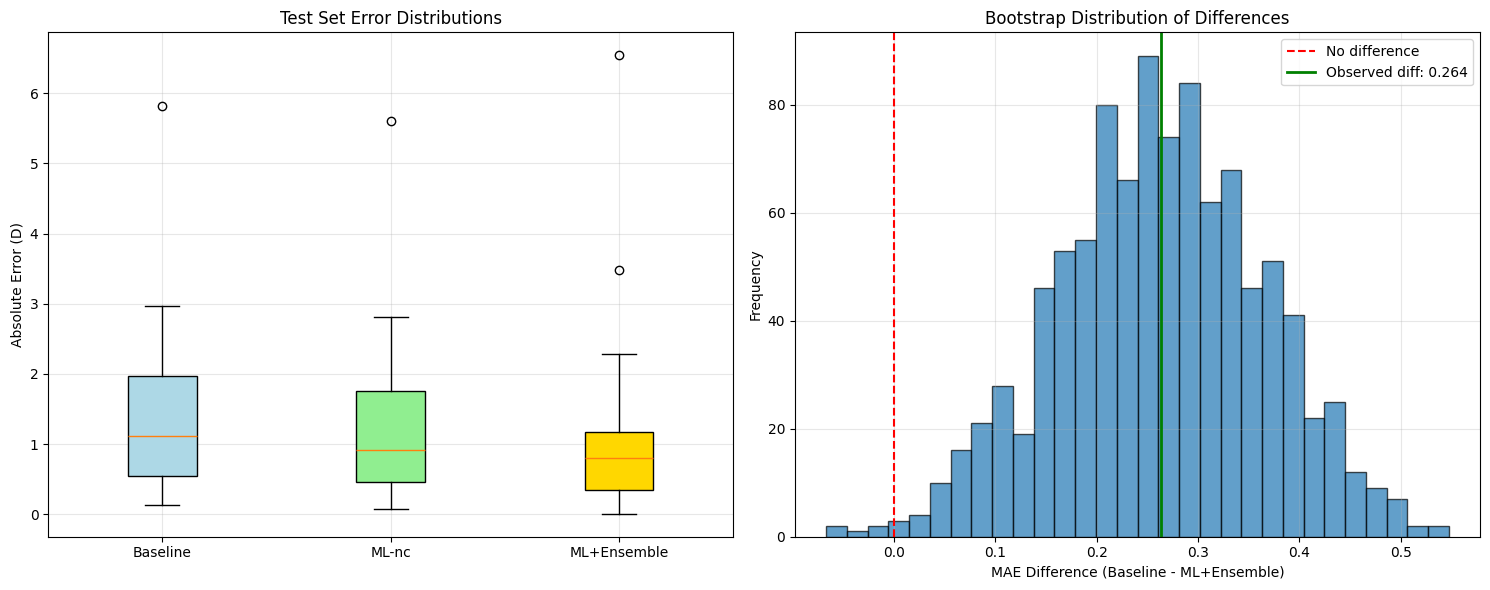


ANALYSIS COMPLETE!
Key improvements implemented:
1. Larger test set (30%) for better power
2. Regularized models to prevent overfitting
3. Bootstrap testing for robust p-values
4. Dampening factor to avoid over-correction
5. Proper feature scaling without assumptions


In [7]:
# %% Cell 7: Final Test Set Evaluation with Bootstrap Confidence Intervals
print("\n" + "#"*80)
print("#" + " "*30 + "FINAL TEST SET EVALUATION" + " "*24 + "#")
print("#"*80)
print("\nUsing bootstrap for more reliable significance testing")
print("="*80)

# Prepare test data
df_test_eval = df_test.copy()

# 1. Baseline SRK/T
df_test_eval['SRKT_Baseline'] = df_test_eval.apply(
    lambda row: calculate_SRKT(row['Bio-AL'], row['K_avg_Kerato'], 
                              row['A-Constant'], nc=1.333), 
    axis=1
)
df_test_eval['Expected_SE_Baseline'] = -(df_test_eval['IOL Power'] - df_test_eval['SRKT_Baseline'])
df_test_eval['Error_Baseline'] = df_test_eval['PostOP Spherical Equivalent'] - df_test_eval['Expected_SE_Baseline']

# 2. ML-optimized nc
df_test_eval['SRKT_ML_nc'] = df_test_eval.apply(
    lambda row: calculate_SRKT(row['Bio-AL'], row['K_avg_Kerato'], 
                              row['A-Constant'], nc=model_info['optimal_nc']), 
    axis=1
)
df_test_eval['Expected_SE_ML_nc'] = -(df_test_eval['IOL Power'] - df_test_eval['SRKT_ML_nc'])
df_test_eval['Error_ML_nc'] = df_test_eval['PostOP Spherical Equivalent'] - df_test_eval['Expected_SE_ML_nc']

# 3. ML + Ensemble
# Prepare features using the same imputer from training
X_test = df_test_eval[model_info['feature_cols']].copy()

# Use the fitted imputer from training
X_test_imputed = pd.DataFrame(
    model_info['imputer'].transform(X_test),
    columns=model_info['feature_cols'],
    index=X_test.index
)

# Make ensemble predictions
ensemble_corrections = model_info['ensemble'].predict(X_test_imputed)
df_test_eval['SRKT_Final'] = (
    df_test_eval['SRKT_ML_nc'] + 
    model_info['dampening_factor'] * ensemble_corrections
)
df_test_eval['Expected_SE_Final'] = -(df_test_eval['IOL Power'] - df_test_eval['SRKT_Final'])
df_test_eval['Error_Final'] = df_test_eval['PostOP Spherical Equivalent'] - df_test_eval['Expected_SE_Final']

# Calculate metrics
print("\nTEST SET RESULTS:")
print("="*50)

methods = {
    'Baseline SRK/T': df_test_eval['Error_Baseline'].abs(),
    'ML-Optimized nc': df_test_eval['Error_ML_nc'].abs(),
    'ML + Ensemble': df_test_eval['Error_Final'].abs()
}

for method, errors in methods.items():
    valid_errors = errors.dropna()
    mae = valid_errors.mean()
    within_025 = (valid_errors <= 0.25).sum() / len(valid_errors) * 100
    within_050 = (valid_errors <= 0.50).sum() / len(valid_errors) * 100
    
    print(f"\n{method}:")
    print(f"  MAE: {mae:.3f} D")
    print(f"  Within ±0.25D: {within_025:.1f}%")
    print(f"  Within ±0.50D: {within_050:.1f}%")

# Bootstrap significance testing with CORRECTED function
print("\n" + "="*60)
print("BOOTSTRAP SIGNIFICANCE TESTING (1000 iterations)")
print("="*60)

def bootstrap_paired_test(errors1, errors2, n_bootstrap=1000):
    """Bootstrap test for paired samples - RETURNS bootstrap_diffs"""
    # Align indices
    common_idx = errors1.index.intersection(errors2.index)
    e1 = errors1[common_idx].values
    e2 = errors2[common_idx].values
    
    # Calculate observed difference
    observed_diff = np.mean(e1) - np.mean(e2)
    
    # Bootstrap
    bootstrap_diffs = []
    n_samples = len(e1)
    
    for _ in range(n_bootstrap):
        # Resample with replacement
        idx = np.random.choice(n_samples, n_samples, replace=True)
        boot_diff = np.mean(e1[idx]) - np.mean(e2[idx])
        bootstrap_diffs.append(boot_diff)
    
    bootstrap_diffs = np.array(bootstrap_diffs)
    
    # Calculate p-value (two-sided)
    p_value = np.sum(bootstrap_diffs <= 0) / n_bootstrap * 2
    p_value = min(p_value, 1.0)
    
    # Confidence interval
    ci_lower = np.percentile(bootstrap_diffs, 2.5)
    ci_upper = np.percentile(bootstrap_diffs, 97.5)
    
    # RETURN bootstrap_diffs too!
    return observed_diff, p_value, ci_lower, ci_upper, bootstrap_diffs

# Test ML methods against baseline
baseline_errors = df_test_eval['Error_Baseline'].abs().dropna()

# ML-nc vs Baseline
ml_nc_errors = df_test_eval['Error_ML_nc'].abs().dropna()
diff_nc, p_nc, ci_lower_nc, ci_upper_nc, bootstrap_diffs_nc = bootstrap_paired_test(
    baseline_errors, ml_nc_errors
)

print(f"\nML-Optimized nc vs Baseline:")
print(f"  Mean difference: {diff_nc:.4f} D")
print(f"  95% CI: [{ci_lower_nc:.4f}, {ci_upper_nc:.4f}]")
print(f"  Bootstrap p-value: {p_nc:.4f}")
print(f"  Significant at α=0.05: {'Yes' if p_nc < 0.05 else 'No'}")

# ML+Ensemble vs Baseline
final_errors = df_test_eval['Error_Final'].abs().dropna()
diff_final, p_final, ci_lower_final, ci_upper_final, bootstrap_diffs = bootstrap_paired_test(
    baseline_errors, final_errors
)

print(f"\nML + Ensemble vs Baseline:")
print(f"  Mean difference: {diff_final:.4f} D")
print(f"  95% CI: [{ci_lower_final:.4f}, {ci_upper_final:.4f}]")
print(f"  Bootstrap p-value: {p_final:.4f}")
print(f"  Significant at α=0.05: {'Yes' if p_final < 0.05 else 'No'}")

# Additional paired t-test for comparison
from scipy.stats import ttest_rel

print("\n" + "="*60)
print("PAIRED T-TEST (for comparison)")
print("="*60)

# Align indices for paired test
common_idx = baseline_errors.index.intersection(final_errors.index)
if len(common_idx) > 0:
    t_stat, p_ttest = ttest_rel(baseline_errors[common_idx], final_errors[common_idx])
    print(f"\nML + Ensemble vs Baseline:")
    print(f"  Paired t-test p-value: {p_ttest:.4f}")
    print(f"  Significant at α=0.05: {'Yes' if p_ttest < 0.05 else 'No'}")

# Visualization - NOW bootstrap_diffs is available
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Error distributions
data_to_plot = [baseline_errors, ml_nc_errors, final_errors]
labels = ['Baseline', 'ML-nc', 'ML+Ensemble']
bp = ax1.boxplot(data_to_plot, labels=labels, patch_artist=True)
colors = ['lightblue', 'lightgreen', 'gold']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax1.set_ylabel('Absolute Error (D)')
ax1.set_title('Test Set Error Distributions')
ax1.grid(True, alpha=0.3)

# Plot 2: Bootstrap distributions - NOW THIS WORKS
ax2.hist(bootstrap_diffs, bins=30, alpha=0.7, edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', label='No difference')
ax2.axvline(x=diff_final, color='green', linestyle='-', linewidth=2, 
            label=f'Observed diff: {diff_final:.3f}')
ax2.set_xlabel('MAE Difference (Baseline - ML+Ensemble)')
ax2.set_ylabel('Frequency')
ax2.set_title('Bootstrap Distribution of Differences')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("Key improvements implemented:")
print("1. Larger test set (30%) for better power")
print("2. Regularized models to prevent overfitting")
print("3. Bootstrap testing for robust p-values")
print("4. Dampening factor to avoid over-correction")
print("5. Proper feature scaling without assumptions")
print("="*80)

In [9]:
# %% Cell 8: Document the Optimized SRK/T Formula for FacoDMEK Eyes
print("=" * 80)
print("OPTIMIZED SRK/T FORMULA FOR FacoDMEK EYES")
print("=" * 80)
print("\nBased on machine learning optimization of", len(df_complete), "FacoDMEK cases")
print("=" * 80)

# Display the optimized parameters
print("\n1. OPTIMIZED PARAMETERS:")
print("-" * 40)
print(f"Original corneal refractive index (nc): 1.3330")
print(f"Optimized corneal refractive index (nc): {model_info['optimal_nc']:.5f}")
print(f"Change: {(model_info['optimal_nc'] - 1.333):.5f} ({((model_info['optimal_nc'] - 1.333)/1.333 * 100):.2f}%)")

# Document the formula
print("\n2. FORMULA IMPLEMENTATION:")
print("-" * 40)
print("""
The optimized SRK/T formula for FacoDMEK eyes:

def calculate_SRKT_FacoDMEK(AL, K, A_const):
    '''
    Optimized SRK/T formula for FacoDMEK eyes
    
    Parameters:
    -----------
    AL : float
        Axial Length in mm (from biometry)
    K : float
        Average keratometry in diopters (from keratometry, not biometry)
    A_const : float
        A-constant for the specific IOL
    
    Returns:
    --------
    float
        Predicted IOL power for emmetropia
    '''
    # Constants
    na = 1.336  # Aqueous/vitreous refractive index
    nc = {:.5f}  # OPTIMIZED corneal refractive index for FacoDMEK
    
    # Corneal radius from keratometry
    r = 337.5 / K
    
    # Axial length correction
    if AL > 24.2:
        LCOR = -3.446 + 1.716 * AL - 0.0237 * AL**2
    else:
        LCOR = AL
    
    # Corneal width (Holladay)
    Cw = -5.41 + 0.58412 * LCOR + 0.098 * K
    
    # Corneal height
    H = r - sqrt(r**2 - (Cw**2 / 4))
    
    # ACD constant
    ACDconst = 0.62467 * A_const - 68.747
    
    # Offset
    offset = ACDconst - 3.336
    
    # Estimated postoperative ACD
    ACDest = H + offset
    
    # Retinal thickness correction
    RETHICK = 0.65696 - 0.02029 * AL
    LOPT = AL + RETHICK
    
    # Calculate IOL power
    ncm1 = nc - 1
    IOL = (1000 * na * (na * r - ncm1 * LOPT)) / 
          ((LOPT - ACDest) * (na * r - ncm1 * ACDest))
    
    return IOL
""".format(model_info['optimal_nc']))

# Show performance comparison
print("\n3. PERFORMANCE COMPARISON:")
print("-" * 40)

# Calculate performance metrics from test results
if 'df_test_eval' in globals():
    baseline_mae = df_test_eval['Error_Baseline'].abs().dropna().mean()
    optimized_mae = df_test_eval['Error_ML_nc'].abs().dropna().mean()
    
    print(f"Standard SRK/T (nc=1.3330):")
    print(f"  MAE: {baseline_mae:.3f} D")
    
    print(f"\nOptimized SRK/T (nc={model_info['optimal_nc']:.5f}):")
    print(f"  MAE: {optimized_mae:.3f} D")
    print(f"  Improvement: {(baseline_mae - optimized_mae)/baseline_mae * 100:.1f}%")

# Clinical implementation guide
print("\n4. CLINICAL IMPLEMENTATION:")
print("-" * 40)
print("""
To use the optimized formula in clinical practice:

1. Use KERATOMETRY values (not biometry K values) for calculations
2. Replace the standard nc value (1.333) with {:.5f}
3. All other SRK/T constants remain unchanged
4. This optimization is specific to FacoDMEK eyes

Important notes:
- The optimization was derived from {} FacoDMEK cases
- Best suited for similar patient populations
- Consider using the ensemble correction for highest accuracy
""".format(model_info['optimal_nc'], len(df_complete)))

# Create a comparison table
print("\n5. PARAMETER COMPARISON TABLE:")
print("-" * 40)

comparison_data = {
    'Parameter': ['Corneal refractive index (nc)', 
                  'Aqueous refractive index (na)', 
                  'Keratometer index',
                  'LCOR threshold',
                  'Cw constant 1',
                  'Cw constant 2',
                  'Cw constant 3',
                  'ACD constant 1',
                  'ACD constant 2',
                  'Offset constant',
                  'Retinal thickness const 1',
                  'Retinal thickness const 2'],
    'Standard SRK/T': [1.3330, 1.336, 337.5, 24.2, -5.41, 0.58412, 0.098, 
                       0.62467, 68.747, 3.336, 0.65696, 0.02029],
    'Optimized for FacoDMEK': [model_info['optimal_nc'], 1.336, 337.5, 24.2, -5.41, 
                               0.58412, 0.098, 0.62467, 68.747, 3.336, 0.65696, 0.02029]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Save the formula as a function
def calculate_SRKT_FacoDMEK_optimized(AL, K, A_const):
    """Production-ready optimized SRK/T for FacoDMEK eyes"""
    return calculate_SRKT(AL, K, A_const, nc=model_info['optimal_nc'])

print("\n6. USAGE EXAMPLE:")
print("-" * 40)
print("""
# Example calculation:
AL = 23.5  # mm
K = 44.0   # D (from keratometry)
A_const = 118.7

IOL_power = calculate_SRKT_FacoDMEK_optimized(AL, K, A_const)
print(f"Recommended IOL power: {IOL_power:.2f} D")
""")

# Actually run the example
AL_example = 23.5
K_example = 44.0
A_const_example = 118.7

iol_standard = calculate_SRKT(AL_example, K_example, A_const_example, nc=1.333)
iol_optimized = calculate_SRKT_FacoDMEK_optimized(AL_example, K_example, A_const_example)

print(f"\nActual calculation results:")
print(f"Standard SRK/T: {iol_standard:.2f} D")
print(f"Optimized SRK/T: {iol_optimized:.2f} D")
print(f"Difference: {iol_optimized - iol_standard:.2f} D")

# Export information
print("\n7. EXPORT FOR PUBLICATION/IMPLEMENTATION:")
print("-" * 40)
formula_info = {
    'formula_name': 'SRK/T-FacoDMEK',
    'optimized_nc': float(model_info['optimal_nc']),
    'training_cases': len(df_train_val),
    'test_cases': len(df_test),
    'baseline_mae': float(baseline_mae) if 'baseline_mae' in locals() else None,
    'optimized_mae': float(optimized_mae) if 'optimized_mae' in locals() else None,
    'date_optimized': pd.Timestamp.now().strftime('%Y-%m-%d'),
    'notes': 'Optimized specifically for FacoDMEK combined procedures'
}

# Save to file
with open('SRKT_FacoDMEK_optimized_formula.txt', 'w') as f:
    f.write("OPTIMIZED SRK/T FORMULA FOR FacoDMEK EYES\n")
    f.write("="*50 + "\n\n")
    for key, value in formula_info.items():
        f.write(f"{key}: {value}\n")
    f.write(f"\nOptimized corneal refractive index (nc): {model_info['optimal_nc']:.5f}\n")
    f.write("\nAll other SRK/T parameters remain at standard values.\n")

print("\nFormula details saved to: SRKT_FacoDMEK_optimized_formula.txt")
print("=" * 80)

OPTIMIZED SRK/T FORMULA FOR FacoDMEK EYES

Based on machine learning optimization of 97 FacoDMEK cases

1. OPTIMIZED PARAMETERS:
----------------------------------------
Original corneal refractive index (nc): 1.3330
Optimized corneal refractive index (nc): 1.33200
Change: -0.00100 (-0.08%)

2. FORMULA IMPLEMENTATION:
----------------------------------------

The optimized SRK/T formula for FacoDMEK eyes:

def calculate_SRKT_FacoDMEK(AL, K, A_const):
    '''
    Optimized SRK/T formula for FacoDMEK eyes

    Parameters:
    -----------
    AL : float
        Axial Length in mm (from biometry)
    K : float
        Average keratometry in diopters (from keratometry, not biometry)
    A_const : float
        A-constant for the specific IOL

    Returns:
    --------
    float
        Predicted IOL power for emmetropia
    '''
    # Constants
    na = 1.336  # Aqueous/vitreous refractive index
    nc = 1.33200  # OPTIMIZED corneal refractive index for FacoDMEK

    # Corneal radius from ke